<a href="https://colab.research.google.com/github/khodozzz/portfolio/blob/main/3_Fake_News_Word2Vec_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

import re, string
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import gensim

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D, Dropout

import sys
import csv

# Data Loading

In [2]:
csv.field_size_limit(sys.maxsize)

131072

In [9]:
news_df = pd.read_csv('WELFake_Dataset.csv', engine='python', error_bad_lines=False)\
    .drop('Unnamed: 0', axis=1)\
    .dropna(subset=['text', 'label'])
news_df.head()

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


# EDA

Count the number of labels

In [7]:
news_df['label'].value_counts()

1    4497
0    4052
Name: label, dtype: int64

Visualize word count distribution

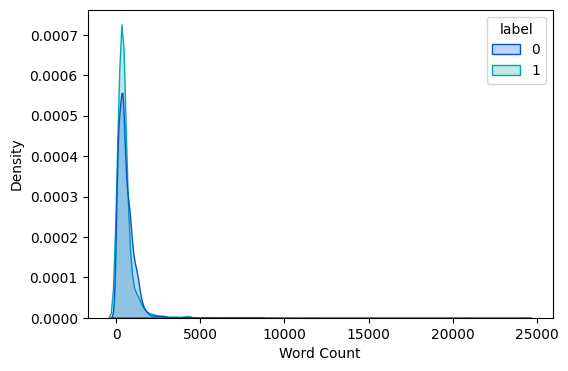

In [8]:
plt.figure(figsize = (6, 4))
sns.kdeplot(x=news_df['text'].apply(lambda x:len(x.split())),
            hue=news_df['label'], palette='winter', fill=True)
plt.xlabel('Word Count')
plt.show()

In [10]:
news_lengths = news_df['text'].apply(lambda x:len(x.split()))
np.percentile(news_lengths, 75)

667.0

Generate wordclouds

In [15]:
def wordcloud_text(text):
    plt.figure(figsize = (10, 8))
    wordcloud = WordCloud(max_words=200, height=600, width=600).generate(text)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

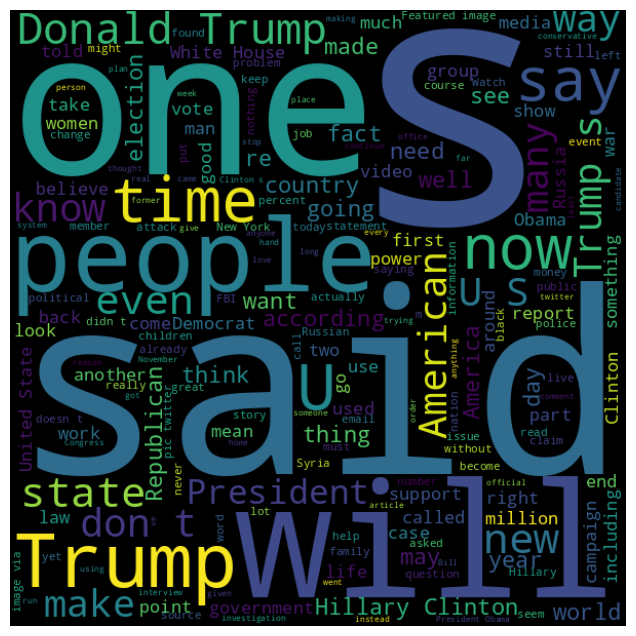

In [16]:
real_text = " ".join(news_df[news_df['label'] == 1]['text'])
wordcloud_text(real_text)

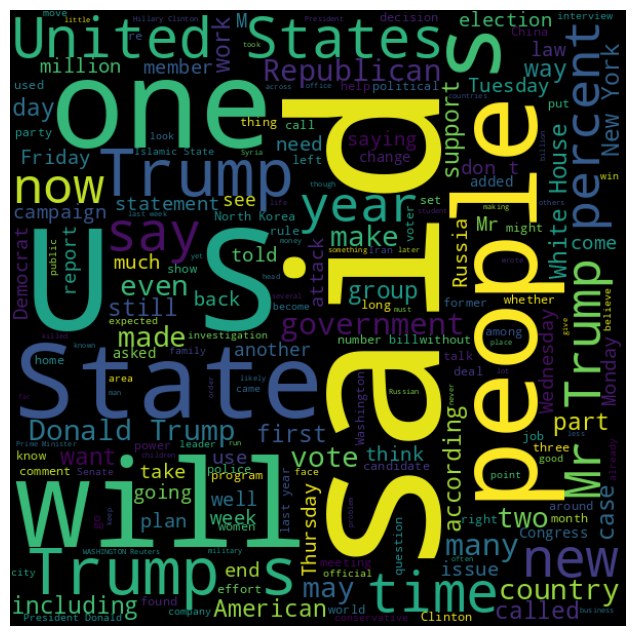

In [17]:
fake_text = " ".join(news_df[news_df['label'] == 0]['text'])
wordcloud_text(fake_text)

# Preproccesing

In [18]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [59]:
max_length = int(np.percentile(np.percentile(news_lengths, 75), 75))

In [40]:
X = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

# Tokenize, filter stopwords, and lemmatize the text
for row in news_df['text'].values:
    tmp = []
    sentences = nltk.sent_tokenize(row)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)

In [42]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(X)
X_tokenized = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_tokenized, maxlen=max_length)

In [61]:
vocab_size = len(tokenizer.word_index) + 1

In [43]:
y = news_df['label'].values

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_padded, y) 

# Word2Vec Model

In [108]:
vector_size = 300

In [100]:
w2v_model = gensim.models.Word2Vec(sentences=X,
                                   vector_size=vector_size,
                                   window=5, 
                                   min_count=1)

In [101]:
w2v_model.wv.most_similar('money')

[('cash', 0.80296790599823),
 ('dollars', 0.7604184150695801),
 ('taxpayer', 0.758964478969574),
 ('donations', 0.7583711743354797),
 ('taxpayers', 0.7449681758880615),
 ('amount', 0.736595869064331),
 ('paying', 0.7299864888191223),
 ('taxes', 0.7284295558929443),
 ('paid', 0.7197802662849426),
 ('attention', 0.7163187265396118)]

Create weight matrix for embedding layer

In [103]:
def get_weight_matrix(model, vocab):
    vocab_size = len(vocab) + 1
    weight_matrix = np.zeros((vocab_size, w2v_model.vector_size))
    
    for word, i in vocab.items():
        weight_matrix[i] = model.wv[word]

    return weight_matrix

In [104]:
embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index)

# Model Training and Evaluation

Training

In [90]:
model = Sequential()

model.add(Embedding(vocab_size, 
                    input_length=max_length,
                    output_dim=vector_size, 
                    weights=[embedding_vectors],  
                    trainable=False))
# model.add(Conv1D(activation='relu', filters=4, kernel_size=4))
# model.add(MaxPool1D())
model.add(LSTM(units=128))
model.add(Dropout(0.1))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [91]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 667, 300)          26286600  
                                                                 
 lstm_8 (LSTM)               (None, 128)               219648    
                                                                 
 dropout_16 (Dropout)        (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 16)                2064      
                                                                 
 dropout_17 (Dropout)        (None, 16)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                 17        
                                                                 
Total params: 26,508,329
Trainable params: 221,729
Non

In [92]:
history = model.fit(X_train, y_train, validation_split=0.3, epochs=5)

Epoch 1/5
141/141 [==============================] - 204s 1s/step - loss: 0.3728 - acc: 0.8404 - val_loss: 0.3342 - val_acc: 0.8664
Epoch 2/5
141/141 [==============================] - 180s 1s/step - loss: 0.2692 - acc: 0.8919 - val_loss: 0.3058 - val_acc: 0.8706
Epoch 3/5
141/141 [==============================] - 197s 1s/step - loss: 0.2217 - acc: 0.9155 - val_loss: 0.2911 - val_acc: 0.8747
Epoch 4/5
141/141 [==============================] - 213s 2s/step - loss: 0.2319 - acc: 0.9080 - val_loss: 0.2559 - val_acc: 0.8872
Epoch 5/5
141/141 [==============================] - 197s 1s/step - loss: 0.1611 - acc: 0.9354 - val_loss: 0.2284 - val_acc: 0.9070


Evaluation 

In [93]:
y_pred = (model.predict(X_test) >= 0.5).astype("int")

67/67 [==============================] - 28s 411ms/step


In [94]:
accuracy_score(y_test, y_pred)

0.9078578110383536